In [1]:
import numpy as np
import pandas as pd

In [2]:
train_features = pd.read_csv('./../data/train_features.csv')
train_targets = pd.read_csv('./../data/train_salaries.csv')
test_data = pd.read_csv('./../data/test_features.csv')

In [3]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
train_features['companyId'] = train_features['companyId'].astype('category')

In [5]:
train_features.dtypes

jobId                    object
companyId              category
jobType                  object
degree                   object
major                    object
industry                 object
yearsExperience           int64
milesFromMetropolis       int64
dtype: object

In [6]:
train_data = pd.merge(train_features, train_targets, on='jobId')

In [170]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

In [171]:
num_features = train_features[['yearsExperience', 'milesFromMetropolis']]

In [172]:
cat_features = train_features[['jobType','degree','major','industry']]

In [173]:
cardinality_features = train_features[['companyId']]

In [174]:
num_pipeline = Pipeline([
    ('imputer1', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler1', RobustScaler())
])

In [175]:
num_transformed = num_pipeline.fit_transform(num_features)

In [176]:
num_transformed

array([[-0.16666667,  0.66      ],
       [-0.75      ,  0.46      ],
       [-0.16666667, -0.24      ],
       ...,
       [ 0.33333333,  0.62      ],
       [-0.5       , -0.9       ],
       [ 0.66666667, -0.78      ]])

In [177]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
    ("encoder", OneHotEncoder()),
])

In [178]:
cat_transformed = cat_pipeline.fit_transform(cat_features)

In [179]:
cat_transformed

<1000000x29 sparse matrix of type '<class 'numpy.float64'>'
	with 4000000 stored elements in Compressed Sparse Row format>

In [180]:
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [181]:
cardinality_pipeline = Pipeline(steps=[
    ("encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
])

In [182]:
train_targets.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [183]:
cardinality_transformed = cardinality_pipeline.fit_transform(cardinality_features)

In [184]:
cardinality_transformed

array([[31.],
       [11.],
       [48.],
       ...,
       [16.],
       [23.],
       [55.]])

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

In [8]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # return X[self.features].values
        return X[[self.features]]

class DummySelector(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None, **fit_params):
        return X
    
    def get_feature_names_out(self, *args, **kwargs):
        return args[0]

In [9]:
pipeline = ColumnTransformer([
    ('id', DummySelector(), ['jobId']),
    ('target', DummySelector(), ['salary']),
], sparse_threshold=0, verbose_feature_names_out=True)

In [10]:
pipeline.fit_transform(train_data)

array([['JOB1362684407687', 130],
       ['JOB1362684407688', 101],
       ['JOB1362684407689', 137],
       ...,
       ['JOB1362685407684', 64],
       ['JOB1362685407685', 149],
       ['JOB1362685407686', 88]], dtype=object)

In [11]:
pipeline.get_feature_names_out()

array(['id__jobId', 'target__salary'], dtype=object)

In [12]:
num_features = ['yearsExperience', 'milesFromMetropolis']
num_pipeline = Pipeline([
    # ('num_features', DataFrameSelector(num_features)),
    ('imputer1', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler1', RobustScaler())
])

In [13]:
cat_features = ['jobType','degree','major','industry']
cat_pipeline = Pipeline([
    # ('cat_features', DataFrameSelector(cat_features)),
    ("imputer", SimpleImputer(missing_values='NONE', strategy="constant", fill_value='OTHER')),
    ("encoder", OneHotEncoder()),
])

In [14]:
cardinality_features = ['companyId']
cardinality_pipeline = Pipeline([
    # ('cardinality_features', DataFrameSelector(cardinality_features)),
    ("imputer", SimpleImputer(missing_values='NONE', strategy="constant", fill_value='OTHER')),
    ("encoder", OrdinalEncoder()),
])

In [15]:
pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline), 
    ('cat_pipeline', cat_pipeline),
    ('cardinality_pipeline', cardinality_pipeline)
])

In [16]:
pipeline = ColumnTransformer([
    ('id', DummySelector(), ['jobId']),
    ('num', num_pipeline, num_features), 
    ('cat', cat_pipeline, cat_features),
    ('car', cardinality_pipeline, cardinality_features),
    ('target', DummySelector(), ['salary'])
], sparse_threshold=0, verbose_feature_names_out=True)

In [17]:
pipeline

ColumnTransformer(sparse_threshold=0,
                  transformers=[('id', DummySelector(), ['jobId']),
                                ('num',
                                 Pipeline(steps=[('imputer1',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler1', RobustScaler())]),
                                 ['yearsExperience', 'milesFromMetropolis']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='OTHER',
                                                                missing_values='NONE',
                                                                strategy='constant')),
                                                 ('encoder', OneHotEncoder())]),
                                 ['jobType', 'degree', 'major', 'industry']),
                                ('car',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='OTHER',
                                                                missing_values='NONE',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OrdinalEncoder())]),
                                 ['companyId']),
                                ('target', DummySelector(), ['salary'])])

In [18]:
train_transformed = pipeline.fit_transform(train_data)

In [19]:
train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [20]:
train_data.dtypes

jobId                    object
companyId              category
jobType                  object
degree                   object
major                    object
industry                 object
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

In [21]:
pipeline.get_feature_names_out() 

array(['id__jobId', 'num__yearsExperience', 'num__milesFromMetropolis',
       'cat__jobType_CEO', 'cat__jobType_CFO', 'cat__jobType_CTO',
       'cat__jobType_JANITOR', 'cat__jobType_JUNIOR',
       'cat__jobType_MANAGER', 'cat__jobType_SENIOR',
       'cat__jobType_VICE_PRESIDENT', 'cat__degree_BACHELORS',
       'cat__degree_DOCTORAL', 'cat__degree_HIGH_SCHOOL',
       'cat__degree_MASTERS', 'cat__degree_OTHER', 'cat__major_BIOLOGY',
       'cat__major_BUSINESS', 'cat__major_CHEMISTRY',
       'cat__major_COMPSCI', 'cat__major_ENGINEERING',
       'cat__major_LITERATURE', 'cat__major_MATH', 'cat__major_OTHER',
       'cat__major_PHYSICS', 'cat__industry_AUTO',
       'cat__industry_EDUCATION', 'cat__industry_FINANCE',
       'cat__industry_HEALTH', 'cat__industry_OIL',
       'cat__industry_SERVICE', 'cat__industry_WEB', 'car__companyId',
       'target__salary'], dtype=object)

In [157]:
train_transformed

array([['JOB1362684407687', -0.16666666666666666, 0.66, ..., 0.0, 31.0,
        130],
       ['JOB1362684407688', -0.75, 0.46, ..., 1.0, 11.0, 101],
       ['JOB1362684407689', -0.16666666666666666, -0.24, ..., 0.0, 48.0,
        137],
       ...,
       ['JOB1362685407684', 0.3333333333333333, 0.62, ..., 0.0, 16.0, 64],
       ['JOB1362685407685', -0.5, -0.9, ..., 0.0, 23.0, 149],
       ['JOB1362685407686', 0.6666666666666666, -0.78, ..., 0.0, 55.0,
        88]], dtype=object)

In [26]:
df = pd.DataFrame(train_transformed, columns = pipeline.get_feature_names_out())

In [27]:
removed_cols = set(['id__jobId', 'target__salary'])
all_cols = df.columns 
train_cols = list(set(all_cols) - removed_cols)
train_cols

['cat__industry_AUTO',
 'cat__jobType_JUNIOR',
 'cat__jobType_VICE_PRESIDENT',
 'cat__industry_FINANCE',
 'cat__major_PHYSICS',
 'cat__industry_HEALTH',
 'cat__jobType_CTO',
 'cat__jobType_JANITOR',
 'num__yearsExperience',
 'car__companyId',
 'cat__industry_OIL',
 'cat__degree_BACHELORS',
 'cat__major_CHEMISTRY',
 'cat__degree_DOCTORAL',
 'cat__major_BUSINESS',
 'cat__industry_EDUCATION',
 'cat__industry_SERVICE',
 'cat__major_ENGINEERING',
 'cat__degree_HIGH_SCHOOL',
 'cat__industry_WEB',
 'cat__jobType_CFO',
 'cat__degree_MASTERS',
 'cat__major_COMPSCI',
 'cat__major_LITERATURE',
 'cat__major_MATH',
 'cat__major_BIOLOGY',
 'num__milesFromMetropolis',
 'cat__jobType_MANAGER',
 'cat__jobType_SENIOR',
 'cat__jobType_CEO',
 'cat__major_OTHER',
 'cat__degree_OTHER']

In [ ]:
df.dtypes

C:\Users\gsund\Anaconda3\envs\salary\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 25.9487	valid_1's rmse: 25.9204
[20]	training's rmse: 21.7203	valid_1's rmse: 21.7173
[30]	training's rmse: 20.0881	valid_1's rmse: 20.1019
[40]	training's rmse: 19.4216	valid_1's rmse: 19.4431
[50]	training's rmse: 19.1453	valid_1's rmse: 19.1719
[60]	training's rmse: 19.0064	valid_1's rmse: 19.0349
[70]	training's rmse: 18.9373	valid_1's rmse: 18.9681
[80]	training's rmse: 18.9037	valid_1's rmse: 18.9378
[90]	training's rmse: 18.8834	valid_1's rmse: 18.9216
[100]	training's rmse: 18.871	valid_1's rmse: 18.9139


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

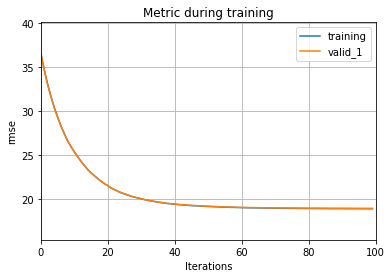

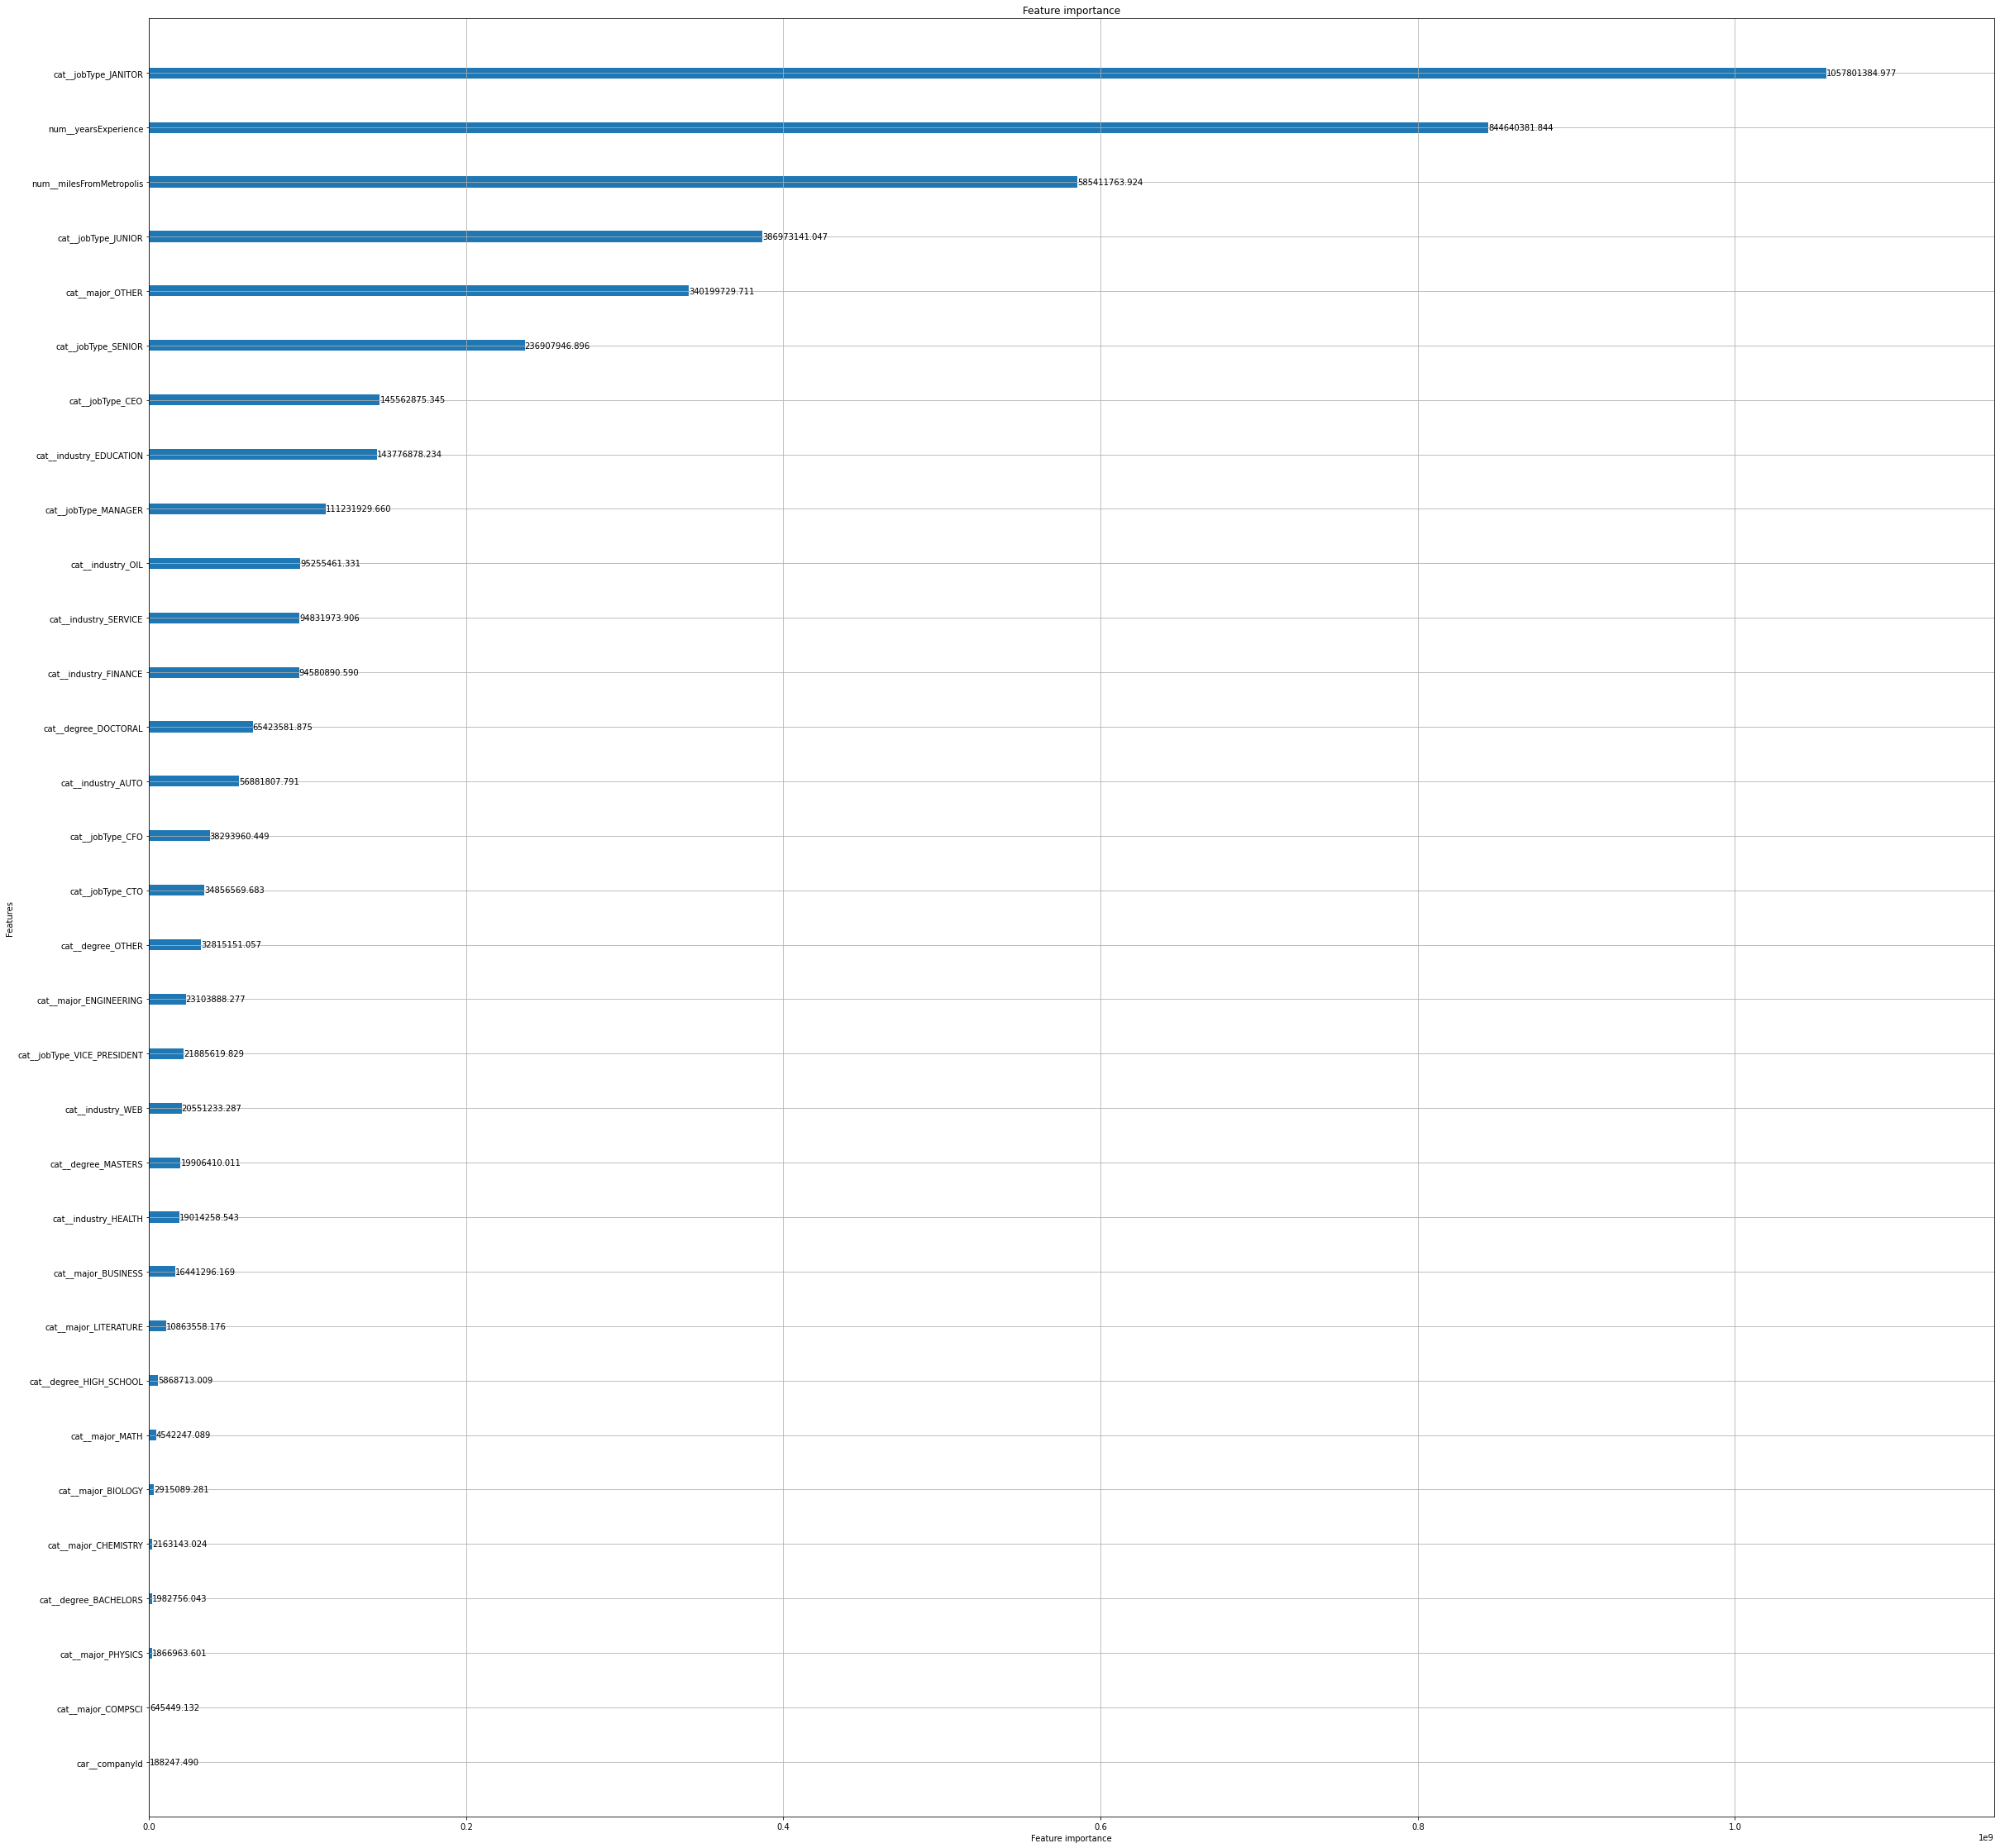

In [170]:
from lightgbm import LGBMRegressor
from lightgbm import plot_metric, plot_tree, plot_importance
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df[train_cols].astype('float'), df['target__salary'].astype('float'), random_state=31)

model = LGBMRegressor(objective='rmse', seed=31, importance_type='gain')
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=10)

ax = plot_metric(model)
fig = ax.get_figure()
fig.savefig('train_val_rmse_comparison.png')

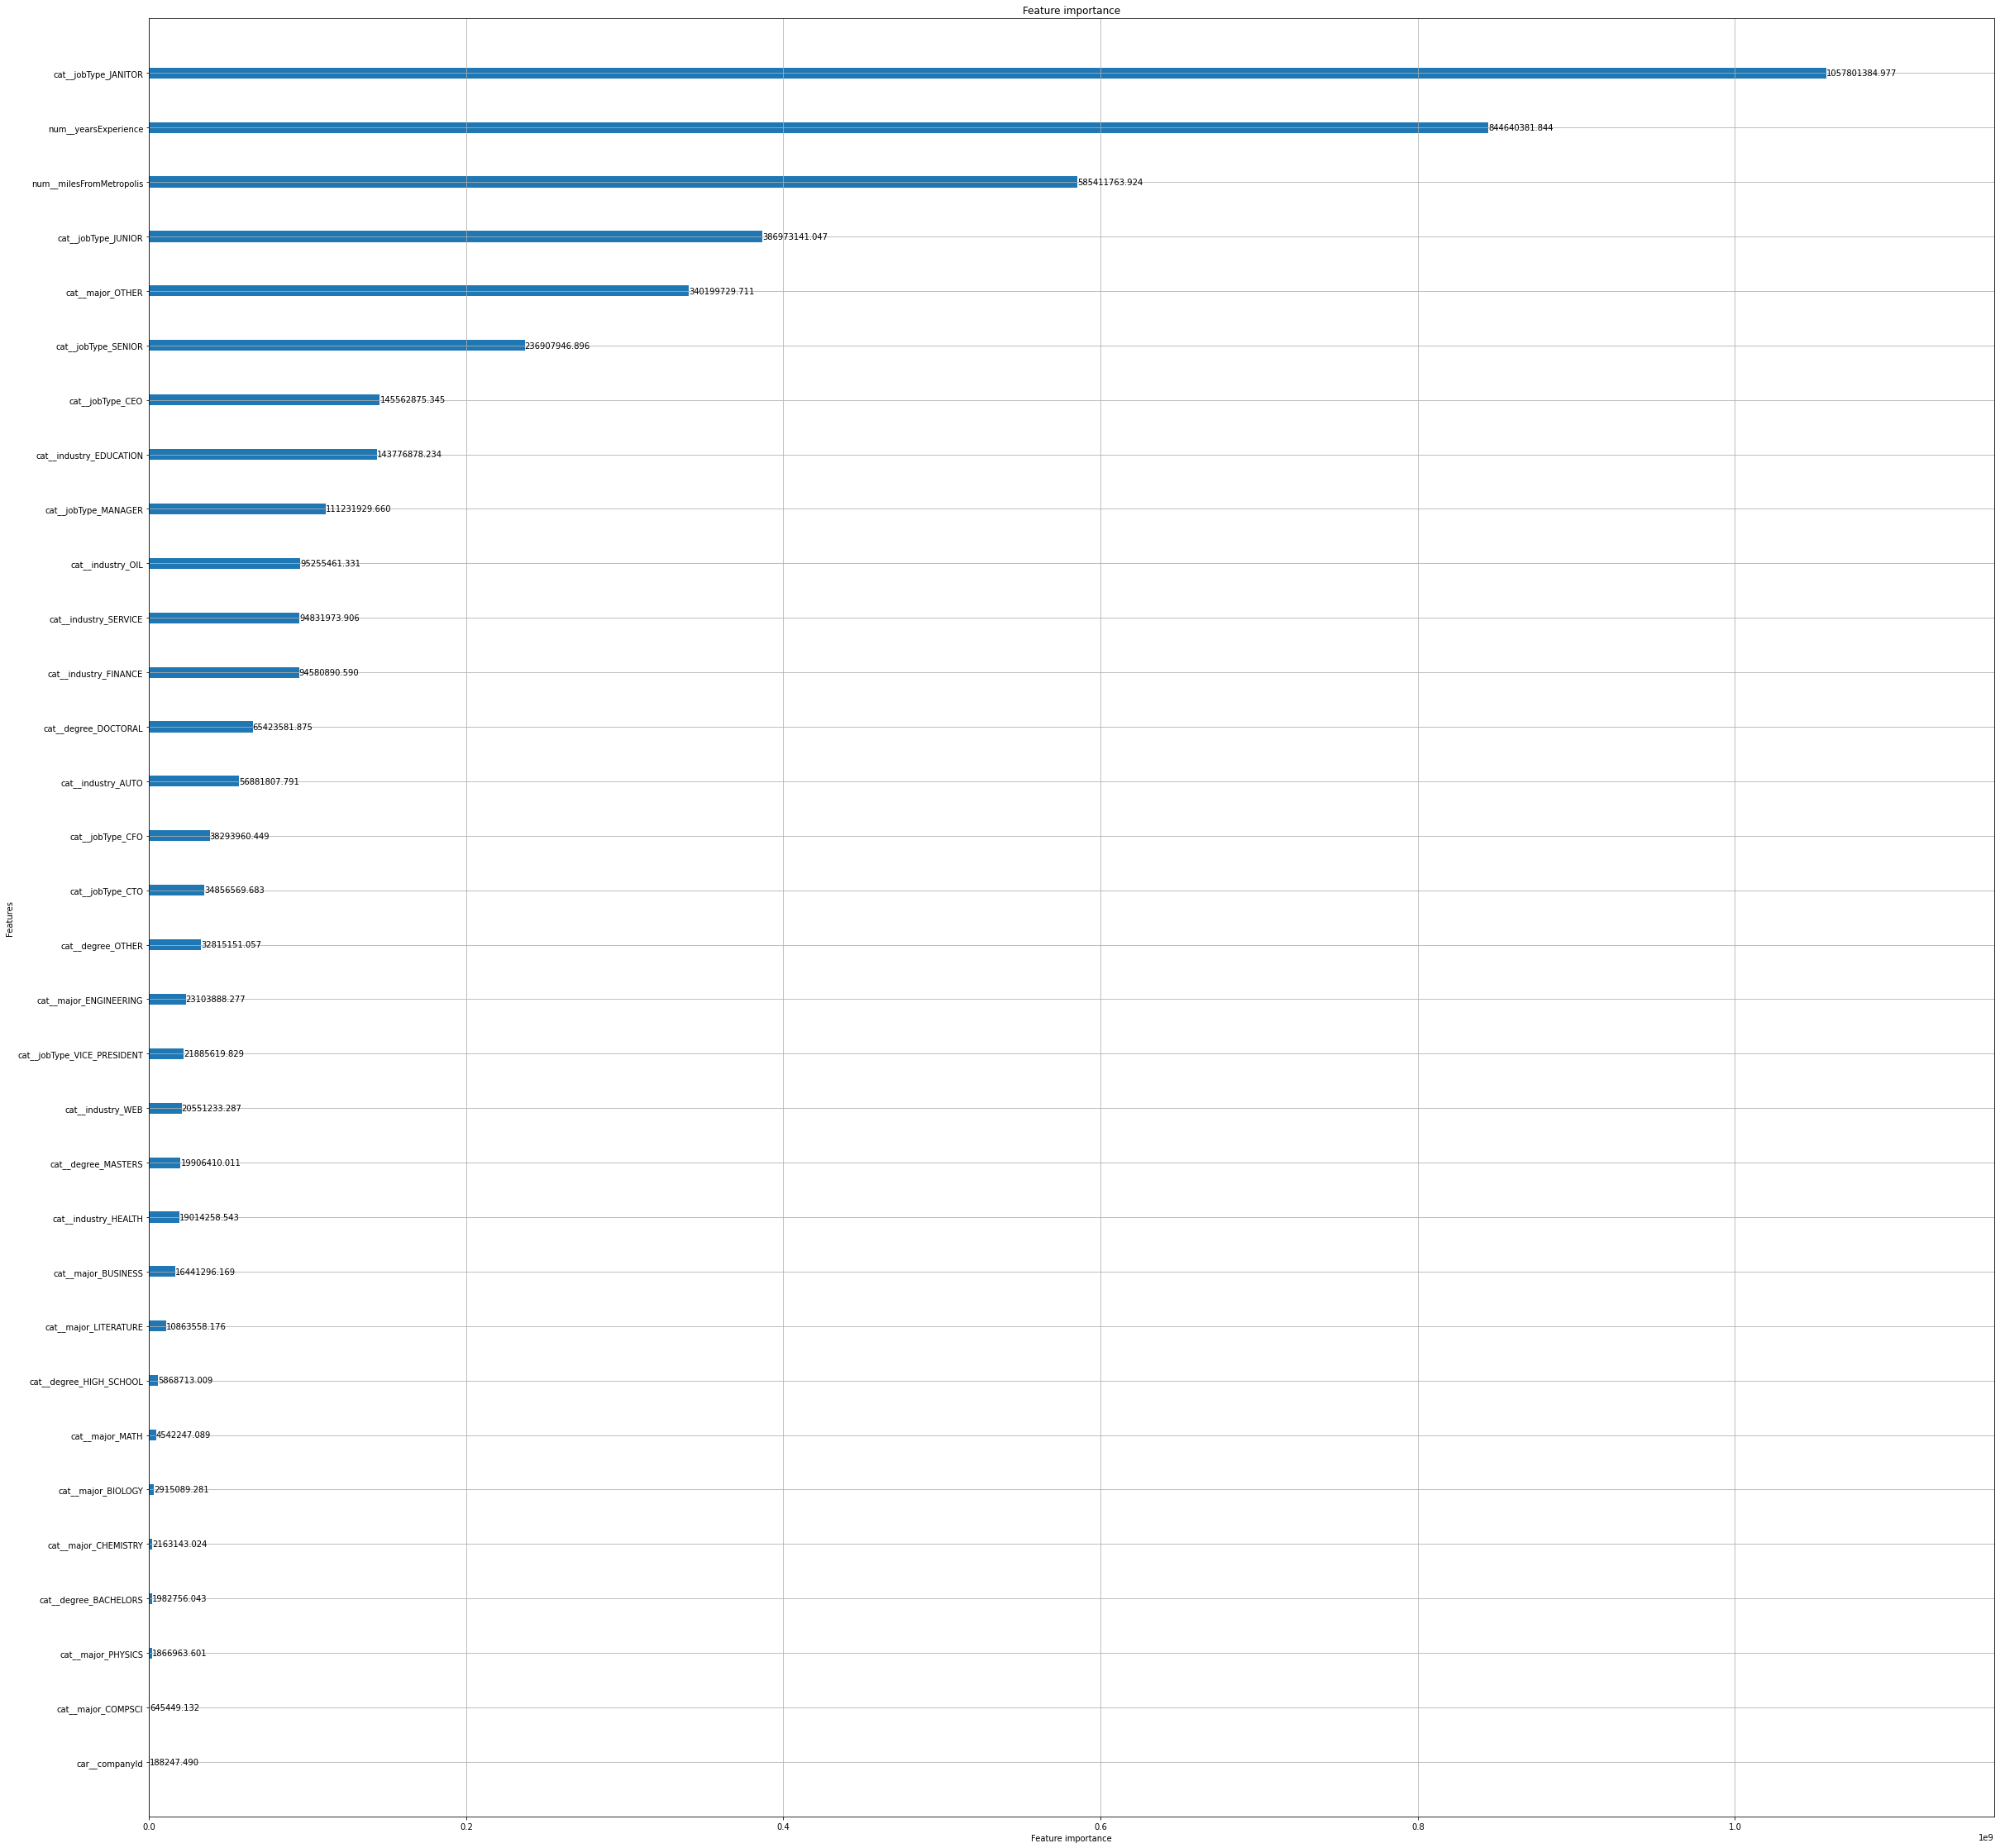

In [176]:
ax = plot_importance(model, ignore_zero=False, figsize=(40, 40))

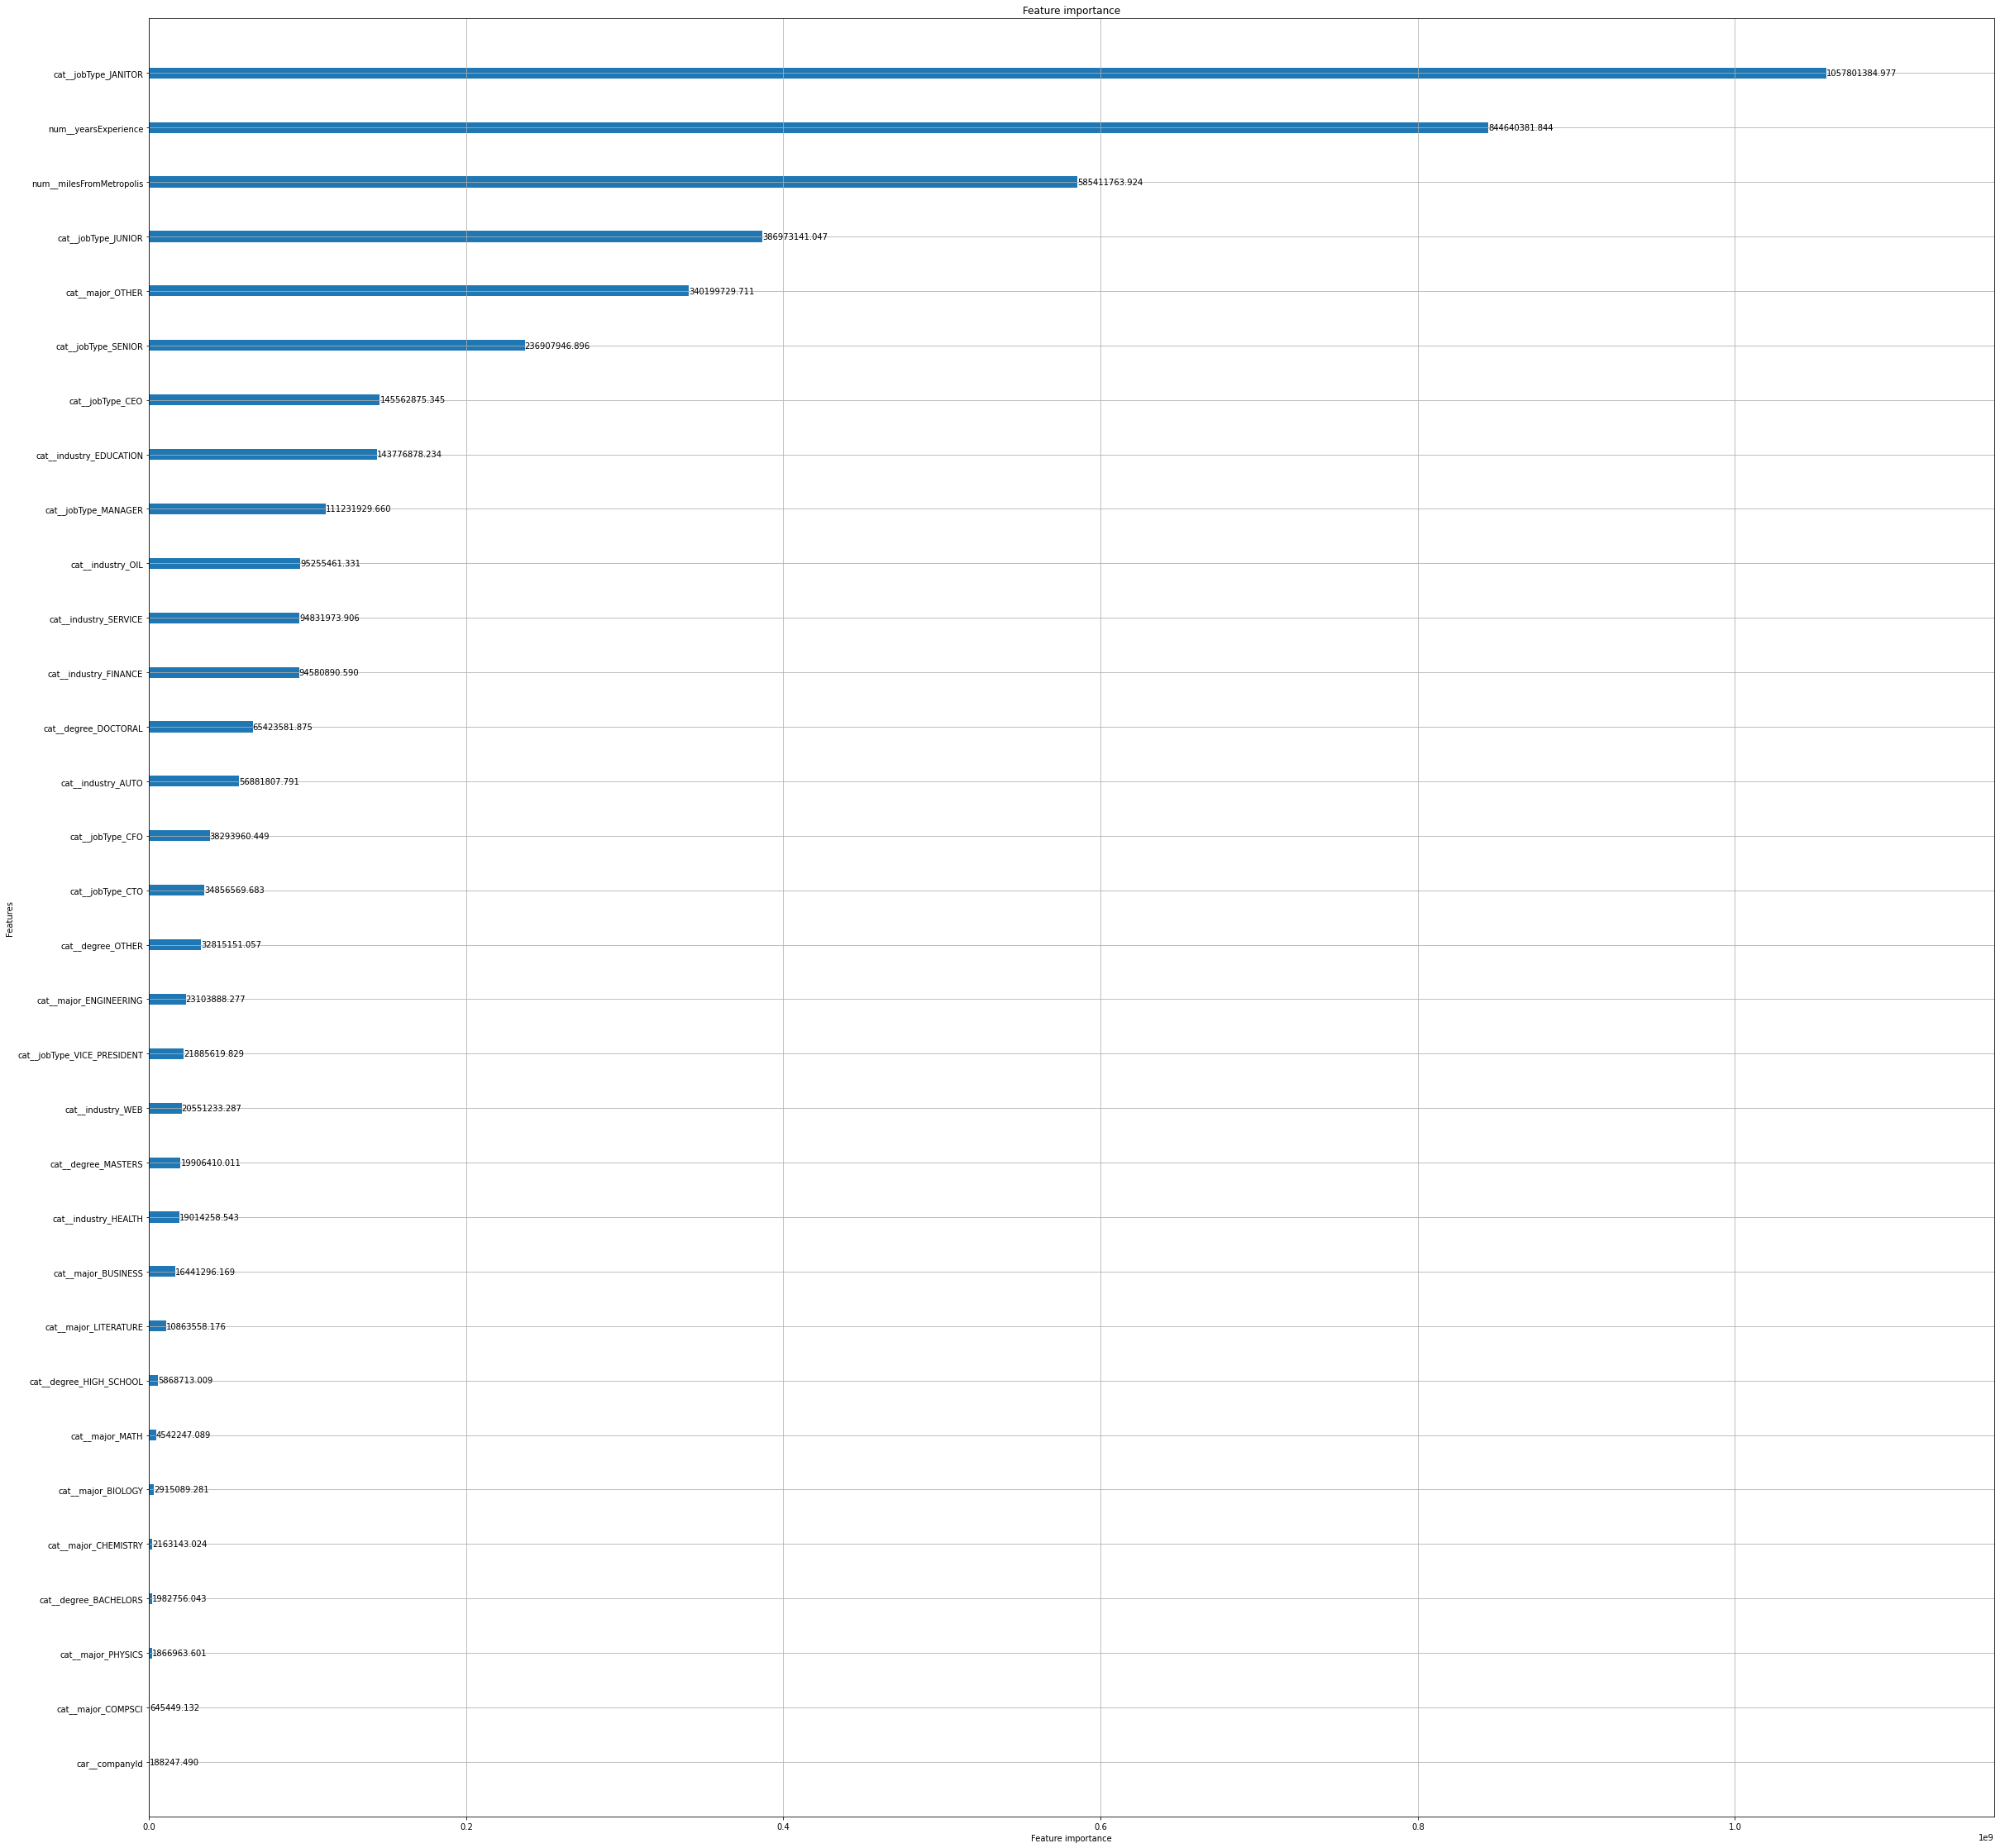

In [177]:
ax.get_figure()

In [23]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

In [33]:
df.rename(columns={'id__jobId': 'jobId'}, inplace=True)

In [35]:
new_train_data = pd.merge(train_data, df[['jobId', 'num__yearsExperience', 'num__milesFromMetropolis']], on='jobId')

In [37]:
new_train_data.drop(['yearsExperience', 'milesFromMetropolis'], axis=1, inplace=True)

In [38]:
new_train_data.rename(columns={'num__yearsExperience': 'yearsExperience', 'num__milesFromMetropolis': 'milesFromMetropolis'}, inplace=True)

In [39]:
new_train_data.head()

,jobId,companyId,jobType,degree,major,industry,salary,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,130,-0.166667,0.66
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,101,-0.75,0.46
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,137,-0.166667,-0.24
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,142,-0.333333,-0.66
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,163,-0.333333,-0.68


In [40]:
train_feature_cols = ['jobId','companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']

In [51]:
X_train, X_val = train_test_split(new_train_data, random_state=31)

In [46]:
model = CatBoostRegressor(cat_features=['companyId','jobType','degree','major','industry'], iterations=200)

In [44]:
train_columns = ['companyId','jobType','degree','major','industry', 'yearsExperience','milesFromMetropolis']
target_feature = 'salary'

In [45]:
new_train_data[train_columns].head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,COMP37,CFO,MASTERS,MATH,HEALTH,-0.166667,0.66
1,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,-0.75,0.46
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,-0.166667,-0.24
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,-0.333333,-0.66
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,-0.333333,-0.68


In [52]:
model.fit(X_train[train_columns], X_train[target_feature], eval_set=(X_val[train_columns], X_val[target_feature]))

Learning rate set to 0.384284
0:	learn: 30.1717047	test: 30.0938549	best: 30.0938549 (0)	total: 407ms	remaining: 1m 21s
1:	learn: 25.5013085	test: 25.4362345	best: 25.4362345 (1)	total: 688ms	remaining: 1m 8s
2:	learn: 22.9752628	test: 22.9306742	best: 22.9306742 (2)	total: 1.11s	remaining: 1m 12s
3:	learn: 21.4441341	test: 21.4066306	best: 21.4066306 (3)	total: 1.48s	remaining: 1m 12s
4:	learn: 20.5982893	test: 20.5575186	best: 20.5575186 (4)	total: 1.77s	remaining: 1m 9s
5:	learn: 20.0544212	test: 20.0070587	best: 20.0070587 (5)	total: 2.11s	remaining: 1m 8s
6:	learn: 19.7827571	test: 19.7414335	best: 19.7414335 (6)	total: 2.4s	remaining: 1m 6s
7:	learn: 19.6104976	test: 19.5748126	best: 19.5748126 (7)	total: 2.81s	remaining: 1m 7s
8:	learn: 19.5135172	test: 19.4782290	best: 19.4782290 (8)	total: 3.28s	remaining: 1m 9s
9:	learn: 19.4434777	test: 19.4080780	best: 19.4080780 (9)	total: 3.66s	remaining: 1m 9s
10:	learn: 19.3652215	test: 19.3351670	best: 19.3351670 (10)	total: 3.96s	rema

In [56]:
eval_results = model.get_evals_result()

In [76]:
eval_results

{'learn': {'RMSE': [30.171704698771656,
   25.501308535409958,
   22.97526282527087,
   21.444134086559895,
   20.598289315301695,
   20.05442124688597,
   19.782757144832313,
   19.610497631681195,
   19.513517227477564,
   19.44347774048389,
   19.365221486596205,
   19.316924226836132,
   19.223316322718766,
   19.182857273388503,
   19.153114570263558,
   19.105987186670816,
   19.08375820014996,
   19.06515426366136,
   19.046413029674273,
   19.020665994467944,
   19.01014537656896,
   18.994911987016526,
   18.988677900722813,
   18.980963009787114,
   18.96819257099532,
   18.959933516448753,
   18.955648564965884,
   18.946767981991865,
   18.942961079919105,
   18.938205583707973,
   18.92919557163239,
   18.920960060814934,
   18.918898941558677,
   18.913507164428577,
   18.910344165919557,
   18.905112493105058,
   18.902657101412178,
   18.89981141848302,
   18.89548472325898,
   18.893891483611224,
   18.89118460496897,
   18.888125450117766,
   18.885666241983795,
   18

In [61]:
eval_df = pd.DataFrame.from_dict(eval_results, orient='index')

In [62]:
eval_df.head()

,RMSE
learn,"[30.171704698771656, 25.501308535409958, 22.97..."
validation,"[30.093854897121055, 25.43623445542137, 22.930..."


In [57]:
import matplotlib.pyplot as plt

In [65]:
train_columns

['companyId',
 'jobType',
 'degree',
 'major',
 'industry',
 'yearsExperience',
 'milesFromMetropolis']

In [66]:
feature_importance = model.get_feature_importance()

In [67]:
feature_importance_map = {}
for col, imp in zip(train_columns, feature_importance):
    feature_importance_map[col] = imp

In [68]:
feature_importance_map

{'companyId': 0.0532768987151289,
 'jobType': 22.25707973326092,
 'degree': 14.733141257113637,
 'major': 3.1177811286462522,
 'industry': 16.0680720611788,
 'yearsExperience': 26.17197975532409,
 'milesFromMetropolis': 17.598669165761088}

C:\Users\gsund\AppData\Local\Temp\ipykernel_23072\1430111906.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('catboost.png', figsize=(20, 30))


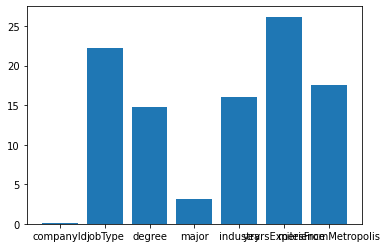

In [75]:
import matplotlib.pyplot as plt

names = train_columns
values = feature_importance

plt.bar(range(len(train_columns)), values, tick_label=names)
plt.savefig('catboost.png', figsize=(20, 30))
# plt.show()

<Figure size 432x288 with 0 Axes>

In [187]:
train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [76]:
import joblib

In [66]:
joblib.dump(pipeline, 'data_config.pkl')

['data_config.pkl']

In [68]:
pipeline = joblib.load('data_config.pkl')

In [69]:
train_transformed = pipeline.fit_transform(train_data)

In [27]:
from sklearn.linear_model import LinearRegression, SGDRegressor

In [33]:
model = LinearRegression()
model.fit(train_transformed, train_data['salary'].values)

LinearRegression()

In [34]:
model1 = SGDRegressor()
model1.fit(train_transformed, train_data['salary'].values)

SGDRegressor()

In [62]:
model1 = SGDRegressor()
model1.fit(train_data_features_1, train_data['salary'].values)

SGDRegressor()

In [35]:
model1

SGDRegressor()

In [36]:
test_transformed = pipeline.transform(test_data)

In [37]:
test_transformed

<1000000x32 sparse matrix of type '<class 'numpy.float64'>'
	with 6934052 stored elements in Compressed Sparse Row format>

In [38]:
model.predict(test_transformed)

array([115.6345518 ,  92.15341442, 166.91661623, ...,  45.10142465,
       164.54575374, 111.80258906])

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

In [51]:
def PolynomialRegression(degree=2, **kwargs):
    return Pipeline([('polynomialfeatures', PolynomialFeatures(degree)), ('linearregression', LinearRegression(**kwargs))])

param_grid = {'polynomialfeatures__degree': np.arange(1,5)}

poly_grid = GridSearchCV(PolynomialRegression(), param_grid, cv=5, scoring='neg_mean_squared_error')

In [52]:
poly_grid.fit(train_transformed, train_data['salary'].values)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': array([1, 2, 3, 4])},
             scoring='neg_mean_squared_error')

In [53]:
help(poly_grid)

Help on GridSearchCV in module sklearn.model_selection._search object:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, iid='deprecated', refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "predict", "predict_proba", "decision_function",
 |  "transform" and "inverse_transform" if they are implemented in the
 |  estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object.
 |      This is assumed to implement the scikit-learn estimator interface.
 |      Either 

In [54]:
poly_grid.cv_results_ 

{'mean_fit_time': array([7.24263334e-01, 1.01954019e+01, 1.85841000e+02, 1.51107209e+03]),
 'std_fit_time': array([1.92391849e-02, 4.11860117e-01, 2.04383892e+01, 5.97989909e+01]),
 'mean_score_time': array([5.26612282e-02, 2.48753214e-01, 9.32571459e-01, 1.57758747e+02]),
 'std_score_time': array([7.43757714e-04, 4.61030003e-03, 1.13329914e-01, 5.80598021e+00]),
 'param_polynomialfeatures__degree': masked_array(data=[1, 2, 3, 4],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'polynomialfeatures__degree': 1},
  {'polynomialfeatures__degree': 2},
  {'polynomialfeatures__degree': 3},
  {'polynomialfeatures__degree': 4}],
 'split0_test_score': array([-386.37860724, -355.89011879, -356.5148025 , -414.24521047]),
 'split1_test_score': array([-385.19275591, -354.48328021, -355.29588534, -411.99864097]),
 'split2_test_score': array([-386.03674438, -355.04774162, -355.67519769, -416.97369407]),
 'split3_test_score': array([-38

In [55]:
poly_grid.best_estimator_

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [56]:
poly_grid.best_params_ 

{'polynomialfeatures__degree': 2}

In [33]:
ploy_features = PolynomialFeatures(degree=2)
train_data_features_1 = ploy_features.fit_transform(train_transformed)

In [34]:
train_data_features_1

<1000000x561 sparse matrix of type '<class 'numpy.float64'>'
	with 35480018 stored elements in Compressed Sparse Row format>

In [37]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [43]:
model3 = LinearRegression()
# model3.fit(train_data_features_1, train_data['salary'].values)

scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error']
scores = cross_validate(model3, train_data_features_1, train_data['salary'].values, scoring=scoring)

In [92]:
model3.fit(train_data_features_1, train_data['salary'].values)

LinearRegression()

In [44]:
scores

{'fit_time': array([ 9.93925858, 10.35009551,  9.97221756, 10.42206287,  9.26027179]),
 'score_time': array([0.02094412, 0.03386211, 0.02094746, 0.02987385, 0.0209434 ]),
 'test_neg_mean_absolute_error': array([-15.3438912 , -15.30051683, -15.32031771, -15.26146883,
        -15.24762769]),
 'test_neg_mean_squared_error': array([-355.89011879, -354.48328021, -355.04774162, -352.71916513,
        -352.32290987]),
 'test_neg_root_mean_squared_error': array([-18.86505019, -18.82772637, -18.84271057, -18.78081908,
        -18.77026664])}

In [45]:
import shap

In [46]:
X100 = shap.utils.sample(train_data_features_1, 100)

In [85]:
X100 = pd.DataFrame.sparse.from_spmatrix(X100)
X100 = X100.astype('float').sparse.to_dense()

In [93]:
explainer = shap.Explainer(model3.predict, X100)

In [87]:
train_data_features_1

<1000000x561 sparse matrix of type '<class 'numpy.float64'>'
	with 35480018 stored elements in Compressed Sparse Row format>

In [88]:
dd = pd.DataFrame.sparse.from_spmatrix(train_data_features_1)

In [89]:
dd = dd.astype('float').sparse.to_dense()

In [90]:
dd.describe(include='all')

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.0,-0.000635,-0.009415,0.124778,0.124369,0.125046,0.124971,0.124594,0.125121,0.125886,...,0.142771,0.0,0.0,4.426956,0.142639,0.0,4.419649,0.143206,4.436773,1291.401940
std,0.0,0.601033,0.577555,0.330467,0.330002,0.330771,0.330686,0.330258,0.330856,0.331721,...,0.349839,0.0,0.0,12.837710,0.349705,0.0,12.824977,0.350283,12.843916,1164.712149
min,1.0,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,1.0,-0.500000,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,225.000000
50%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,961.000000
75%,1.0,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2209.000000
max,1.0,1.000000,0.980000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,0.0,62.000000,1.000000,0.0,62.000000,1.000000,62.000000,3844.000000


In [96]:
dd_sample = dd.sample(n=1000)

In [97]:
shap_values = explainer(dd_sample, max_evals=1300)
# shap.TreeExplainer(lgbm)

Permutation explainer: 1001it [03:34,  4.44it/s]                                                                       


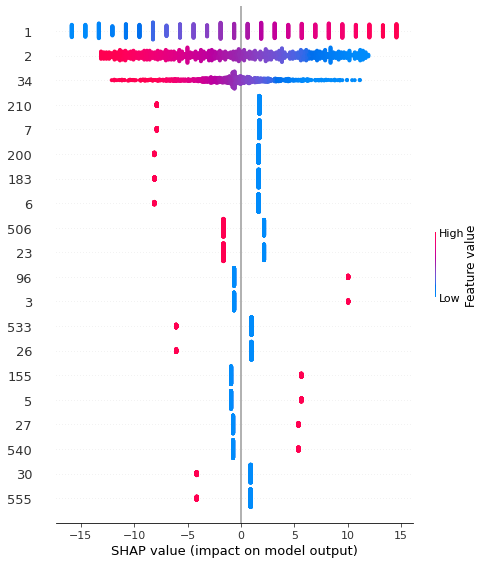

In [99]:
shap.summary_plot(shap_values, dd_sample)

In [194]:
from lightgbm import LGBMRegressor
from lightgbm import plot_metric, plot_tree, plot_importance
from sklearn.model_selection import train_test_split

In [195]:
X_train, X_val, y_train, y_val = train_test_split(train_transformed, train_data['salary'].values, random_state=31)

model = LGBMRegressor(objective='rmse', seed=31)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=10)

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[10]	training's rmse: 25.9487	valid_1's rmse: 25.9204
[20]	training's rmse: 21.7203	valid_1's rmse: 21.7173
[30]	training's rmse: 20.0881	valid_1's rmse: 20.1019
[40]	training's rmse: 19.4216	valid_1's rmse: 19.4431
[50]	training's rmse: 19.1453	valid_1's rmse: 19.1719
[60]	training's rmse: 19.0064	valid_1's rmse: 19.0349
[70]	training's rmse: 18.9373	valid_1's rmse: 18.9681
[80]	training's rmse: 18.9037	valid_1's rmse: 18.9378
[90]	training's rmse: 18.8834	valid_1's rmse: 18.9216
[100]	training's rmse: 18.871	valid_1's rmse: 18.9139


LGBMRegressor(objective='rmse', seed=31)

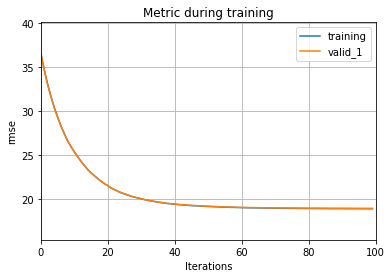

In [196]:
ax = plot_metric(model)
fig = ax.get_figure()
fig.savefig('train_val_rmse_comparison.png')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

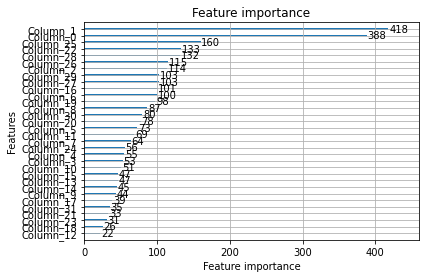

In [198]:
plot_importance(model, ignore_zero=False)

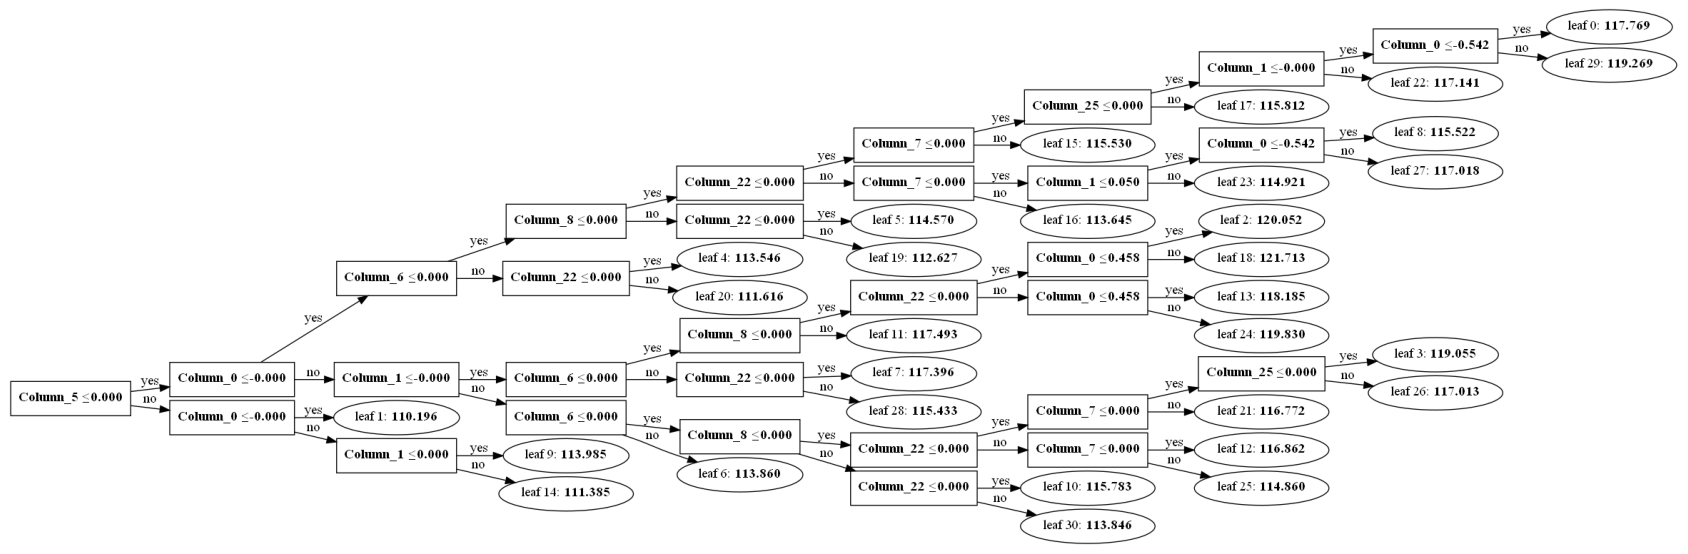

In [139]:
ax = plot_tree(model, figsize=(30, 30))

In [153]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_val)

In [155]:
shap_values

<250000x32 sparse matrix of type '<class 'numpy.float64'>'
	with 8000000 stored elements in Compressed Sparse Row format>

In [144]:
fig = ax.get_figure()

In [145]:
fig.savefig("output.png")

In [128]:
lgbm.predict(train_transformed)

array([125.88834807, 114.28716279, 140.83967393, ...,  65.30804902,
       133.14373623, 112.52060446])

In [112]:
from sklearn.model_selection import learning_curve

In [113]:
train_sizes, train_scores, valid_scores = learning_curve(lgbm, train_transformed, train_data['salary'].values, 
                                                         train_sizes=[50, 80, 110], cv=5)

In [115]:
valid_scores

array([[ 0.10045773,  0.20645459,  0.20815328,  0.20580537,  0.2093053 ],
       [-0.06219442,  0.0526223 ,  0.05323802,  0.04870795,  0.05373493],
       [ 0.17070962,  0.23085817,  0.23452448,  0.23039957,  0.23109244]])

In [116]:
import matplotlib.pyplot as plt

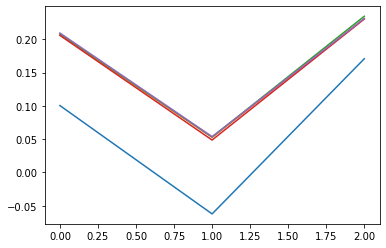

In [117]:
plt.plot(valid_scores)